In [1]:
import numpy as np
import matplotlib.pyplot as plt
from OCP_algorithms import hospital_capacity_objective_solve, quadratic_objective_solve, week_objective_solve

from SIR_Plotting_Routines import *
import pysindy as ps
import glob
import pandas as pd


from os.path import basename
import os
import sys


cwd = os.path.dirname(os.path.abspath(''))
# sys.path.append(cwd + '/Cpp/build/Binders/')
import pyFROLS as pf

DATA_DIR = cwd + '/Cpp/data/'
FIGURE_DIR = cwd + '/../../figures/'

In [2]:
d_max = 1
N_output_max = 80
Nx = 3
Nu = 1
Nt = 50
er_model = pf.Polynomial_Model(Nx,Nu,N_output_max,d_max)
# er_features = er_model.read_csv(DATA_DIR + 'ERR_Simulation_SIR_' + str(N_pop) + '_' + str(p_ER) + '/param.csv')


In [3]:
qr_model = pf.Polynomial_Model(Nx,Nu,N_output_max,d_max)
# qr_features = qr_model.read_csv(DATA_DIR + 'Quantile_Simulation_SIR_' + str(N_pop) + '_' + str(p_ER) + '/param.csv')

In [4]:
from pysindy_casadi_converter import construct_mx_equations
import casadi as cs


In [5]:
import random
N_sims = 50
p_I0 = 0.2
x_names = [r'$S_{t}$', r'$I_{t}$', r'$R_{t}$']
u_names = [r'$p_{I}$']
y_names = [r'$S_{t+1}$', r'$I_{t+1}$', r'$R_{t+1}$']
# #generate integer seeds
# qr_seeds = [random.randint(0, 1000000) for i in range(N_sims)]
from copy import deepcopy
# er_sims = pf.Bernoulli_SIR_MC_Simulations(N_pop, p_ER, p_I0, er_seeds, Nt, 100)
# qr_sims = pf.Bernoulli_SIR_MC_Simulations(N_pop, p_ER, p_I0, qr_seeds, Nt, 100)
# er_X_list = [np.array([x[0], x[1], x[2]]) for x in er_sims]
# qr_X_list = [np.array([x[0], x[1], x[2]]) for x in qr_sims]
graph_seed = 777
p_gen = pf.MC_SIR_Params()
p_gen.N_pop = 20
p_gen.p_I0 = 0.2
er_param = pf.Regressor_Param()
er_param.tol = 1e-4
er_param.N_terms_max = 2
er_regressor = pf.ERR_Regressor(er_param)
qr_param = pf.Quantile_Param()
qr_param.tol = 1e-3
qr_param.N_terms_max = 2
qr_param.tau = .95
qr_regressor = pf.Quantile_Regressor(qr_param)

qr_param.tau = 0.05
reverse_qr_regressor = pf.Quantile_Regressor(qr_param)

er_seeds = [random.randint(0, 1000000) for i in range(N_sims)]
def openloop_solve(N_pop, p_ER, er_regressor, er_model, qr_regressor, qr_model,seed, N_sims, Nt, Wu):
    p_gen = pf.MC_SIR_Params()
    p_gen.R0_max = 3
    p_gen.N_pop = N_pop
    p_gen.p_ER = p_ER
    p_gen.p_I0 = 0.2
    p_gen.N_I_min = 0
    #set numpy random seed
    np.random.seed(seed)
    #generate integer seeds
    seeds = [random.randint(0, 1000000) for i in range(N_sims)]
    x = cs.MX.sym('x', 3)
    u = cs.MX.sym('u', 1)
    G_structure = pf.generate_SIR_ER_graph(N_pop, p_ER, seed)
    G = pf.generate_Bernoulli_SIR_Network(G_structure, p_I0, seed, 0)
    G_mpc = G
    #generate integer seeds
    seeds = [random.randint(0, 1000000) for i in range(N_sims)]
    rd = pf.MC_SIR_simulations_to_regression(G_structure, p_gen, seeds, Nt)
    X_mean = np.mean(np.reshape(rd.X, (N_sims, Nt, Nx)), axis=0)
    U_mean = np.mean(np.reshape(rd.U, (N_sims, Nt, Nu)), axis=0)
    
    #Quantile Regression and optimiation
    
    er_features = er_regressor.transform_fit(rd, er_model)
    er_model.write_latex(er_features, DATA_DIR + '/latex/param/er_param_{}_{}.tex'.format(N_pop, p_ER), x_names, u_names, y_names, False, "&")

    F_ODE = cs.Function("F_ODE", [x, u], [cs.vertcat(*construct_mx_equations(x, u, er_model, er_features))])
    log_filename = log_file=DATA_DIR + '/latex/log/er_week_objective_solve_{}_{}.txt'.format(N_pop, p_ER)
    er_sol, er_x_pred, er_u_sol, er_stats = week_objective_solve(X_mean, U_mean, Wu, F_ODE, Nt, N_pop, log_file=log_filename)

    #Quantile Regression and optimiation
    qr_feature_S = reverse_qr_regressor.transform_fit(rd.X, rd.U, rd.Y[:,0], qr_model)
    qr_feature_I = qr_regressor.transform_fit(rd.X, rd.U, rd.Y[:,1], qr_model)
    qr_feature_R = qr_regressor.transform_fit(rd.X, rd.U, rd.Y[:,2], qr_model)
    # qr_features = qr_regressor.transform_fit(rd, qr_model)
    qr_features = [qr_feature_S, qr_feature_I, qr_feature_R]
    qr_model.write_latex(er_features, DATA_DIR + '/latex/param/qr_param_{}_{}.tex'.format(N_pop, p_ER), x_names, u_names, y_names, False, "&")
    F_ODE = cs.Function("F_ODE", [x, u], [cs.vertcat(*construct_mx_equations(x, u, qr_model, qr_features))])
    log_filename = log_file=DATA_DIR + '/latex/log/qr_week_objective_solve_{}_{}.txt'.format(N_pop, p_ER)    
    qr_sol, qr_x_pred, qr_u_sol, qr_stats = week_objective_solve(X_mean, U_mean, Wu, F_ODE, Nt, N_pop, log_file=log_filename)


    #FROLS simulations

    mpc_sir_p = [pf.SIR_Param() for i in range(Nt)]
    for i in range(Nt):
        mpc_sir_p[i].p_R = 0.1
        mpc_sir_p[i].p_I = er_u_sol[i]
        mpc_sir_p[i].N_I_min = 0        

    seeds = [random.randint(0, 1000000) for i in range(N_sims)]
    er_mpc_rd = pf.MC_SIR_simulations_to_regression(G_structure, p_gen, mpc_sir_p, seeds, Nt)

    #Quantile simulations

    for i in range(Nt):
        mpc_sir_p[i].p_R = 0.1
        mpc_sir_p[i].p_I = qr_u_sol[i]
        mpc_sir_p[i].N_I_min = 0   

    seeds = [random.randint(0, 1000000) for i in range(N_sims)]
    qr_mpc_rd = pf.MC_SIR_simulations_to_regression(G_structure, p_gen, mpc_sir_p, seeds, Nt)

    qr_data = {'X': qr_mpc_rd.X, 'U': qr_mpc_rd.U, 'features': qr_features,
               'x_pred': qr_x_pred, 'u_sol': qr_u_sol, 'sol': qr_sol, 'stats': qr_stats}

    er_data = {'X': er_mpc_rd.X, 'U': er_mpc_rd.U, 'features': er_features,
                'x_pred': er_x_pred, 'u_sol': er_u_sol, 'sol': er_sol, 'stats': er_stats}

    uncontrolled_data = {'X': rd.X, 'U': rd.U, 'X_mean': X_mean, 'U_mean': U_mean}

    return er_data, qr_data, uncontrolled_data
    

Solving for N_pop = 30, p_ER = 0.1

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

[Regressor] Warning: threshold is too high for candidates
Solving for N_pop = 30, p_ER = 1.0
Solving for N_pop = 100, p_ER = 0.1
Solving for N_pop = 100, p_ER = 1.0


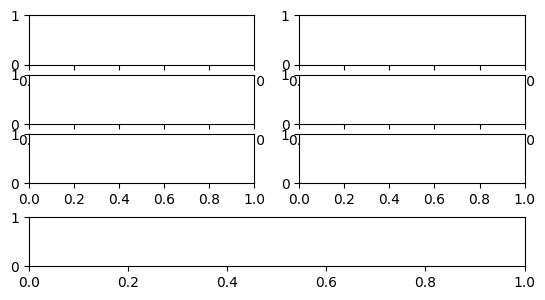

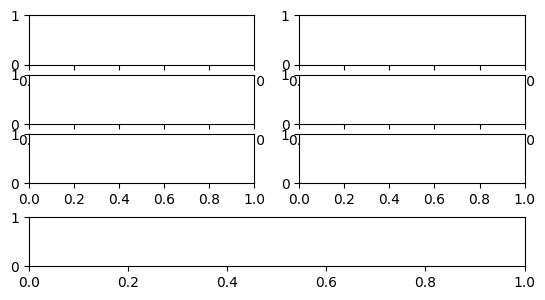

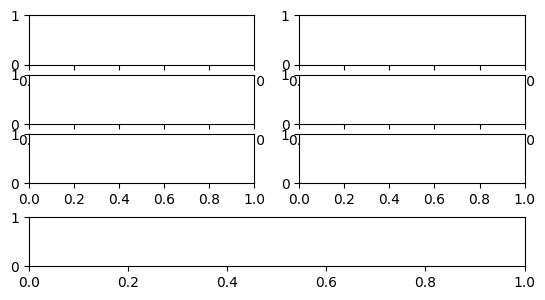

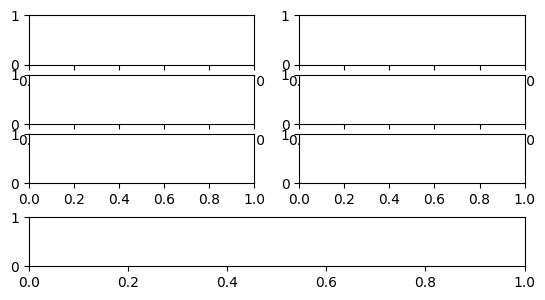

In [6]:
seed = random.randint(0, 1000000)
Wu = 50
from copy import deepcopy
uc_datas = []
G_param_pairs = []
N_pops = [30, 100]
p_ERs = [0.1,1.0]
t = np.array(range(Nt))
uncontrolled_traj_fname = lambda p: DATA_DIR + '/latex/Figures/MPC_Trajectory_comparison_{}_{}.pdf'.format(p[0], p[1])

for N_pop in N_pops:
    for p_ER in p_ERs:
        G_param_pairs.append((N_pop, p_ER))
for p in G_param_pairs:
    print('Solving for N_pop = {}, p_ER = {}'.format(p[0], p[1]))
    qr_data, er_data, uc_data = openloop_solve(p[0], p[1], er_regressor, er_model, qr_regressor, qr_model, seed, N_sims, Nt, Wu)
    mpc_trajectory_plot(p, er_data, qr_data, t, uncontrolled_traj_fname(p))
    uc_datas.append(uc_data)


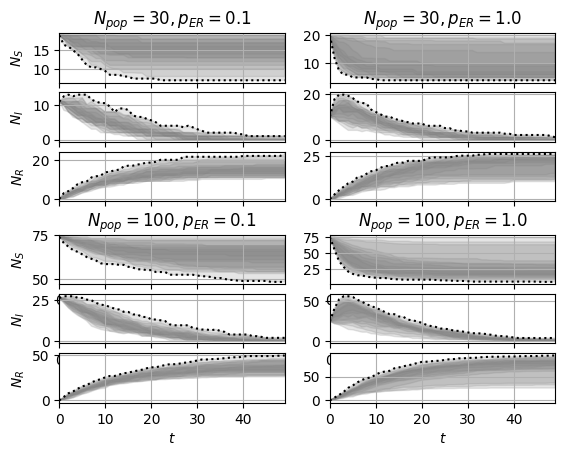

In [7]:

t = np.array(range(Nt))
uncontrolled_traj_fname = DATA_DIR + '/latex/Figures/MPC_Trajectory_comparison.pdf'
plot_uncontrolled(G_param_pairs, uc_datas, t, uncontrolled_traj_fname)

In [8]:
uc_datas[0]['X']

array([[19., 11.,  0.],
       [16., 14.,  0.],
       [16., 13.,  1.],
       ...,
       [19.,  0., 11.],
       [19.,  0., 11.],
       [19.,  0., 11.]], dtype=float32)